In [14]:
from keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D 
from keras.layers import Activation, Dropout, Flatten, Dense 
from keras import backend as K 


import tensorflow as tf 
tf.test.gpu_device_name() 


'/device:GPU:0'

In [15]:

from google.colab import drive 
drive.mount('/mntDrive') 


Drive already mounted at /mntDrive; to attempt to forcibly remount, call drive.mount("/mntDrive", force_remount=True).


In [0]:
img_width, img_height = 400, 400
  
train_data_dir = '/mntDrive/My Drive/Colab Notebooks/Combo/Training'
validation_data_dir = '/mntDrive/My Drive/Colab Notebooks/Combo/Testing'
nb_train_samples = 840 
nb_validation_samples = 210
epochs = 50
batch_size = 16

In [0]:
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [0]:

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(7))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [34]:
train_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True) 
  
test_datagen = ImageDataGenerator(rescale=1. / 255) 
  
train_generator = train_datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical') 
  
validation_generator = test_datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical') 
  
model.fit_generator( 
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs, 
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size) 


Found 840 images belonging to 7 classes.
Found 210 images belonging to 7 classes.
Epoch 1/50
52/52 [==============================] - 87s 2s/step - loss: 2.1052 - acc: 0.1815 - val_loss: 1.8166 - val_acc: 0.3029
Epoch 2/50
52/52 [==============================] - 31s 605ms/step - loss: 1.8664 - acc: 0.2559 - val_loss: 1.7853 - val_acc: 0.2887
Epoch 3/50
52/52 [==============================] - 31s 598ms/step - loss: 1.7876 - acc: 0.2956 - val_loss: 1.6598 - val_acc: 0.3402
Epoch 4/50
52/52 [==============================] - 31s 595ms/step - loss: 1.7585 - acc: 0.3005 - val_loss: 1.6739 - val_acc: 0.3557
Epoch 5/50
52/52 [==============================] - 31s 596ms/step - loss: 1.6944 - acc: 0.3606 - val_loss: 1.7010 - val_acc: 0.3557
Epoch 6/50
52/52 [==============================] - 31s 592ms/step - loss: 1.7046 - acc: 0.3450 - val_loss: 1.6140 - val_acc: 0.3918
Epoch 7/50
52/52 [==============================] - 31s 601ms/step - loss: 1.6340 - acc: 0.3594 - val_loss: 2.0640 - val_ac

In [0]:
model.save_weights('/mntDrive/My Drive/Colab Notebooks/model_masks_saved_7cat.h5') 

In [36]:
classes = train_generator.class_indices
print(classes)

{'braids': 0, 'curly': 1, 'dreadlocks': 2, 'kinky': 3, 'short_men': 4, 'straight': 5, 'wavy': 6}


In [0]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image

In [39]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

#compile the 3-layer CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(7))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

#load weights into new model
model.load_weights('/mntDrive/My Drive/Colab Notebooks/model_masks_saved_7cat.h5')


#GENERATE CONFUSION MATRIX, ITERATE OVER ALL TEST IMAGES
#path to folder where test images are located
path = '/mntDrive/My Drive/Colab Notebooks/Combo/Testing/'
files = os.listdir(path)

y_true = [] #list of ground truth labels, will be plugged into sklearn confusion matrix
y_pred = [] #list of predicted labels
dict_labels = {0:'braids', 1:'curly', 2:'dreadlocks', 3:'kinky', 4:'short_men', 5:'straight', 6:'wavy'}

#iterate over every subfolder, and every image in each subfolder
#subfolders correspond to each class
for file in files:
    if os.path.isdir(os.path.join(path, file)):
        label_true = file #label all files in this folder as name of folder
        path_subfolder = path + file
        subfiles = os.listdir(path_subfolder) #list of all files in subfolder
        for subfile in subfiles:
            if subfile == '.DS_Store':
                continue
            img_path = os.path.join(path_subfolder, subfile)
            #load image
            img = image.load_img(img_path, target_size = (img_width, img_height))
            img_tensor = image.img_to_array(img)
            img_tensor = np.expand_dims(img_tensor, axis=0)
            img_tensor /= 255

            pred = model.predict(img_tensor) #make prediction
            label_pred = dict_labels[np.argmax(pred[0])]

            y_true.append(label_true) #append true label
            y_pred.append(label_pred) #append predicted label


#generate, print the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['braids', 'curly','dreadlocks', 'kinky','short_men','straight', 'wavy'])
print(cm)

[[12  4  6  4  0  3  1]
 [ 6 11  4  4  0  1  4]
 [ 6  1 20  2  0  1  0]
 [ 2  6  2 17  1  1  1]
 [ 4  2  0  6 14  1  3]
 [ 8  3  4  3  1  4  7]
 [ 3  7  3  3  0  2 12]]


In [0]:
import matplotlib.pyplot as plt
import numpy as np

In [29]:
print(np.flipud(np.fliplr(cm)))

[[ 4  2  6 16  2]
 [ 8  3  4 13  2]
 [24  3 12 45  6]
 [ 5  2  5 17  1]
 [11  0  4 14  1]]


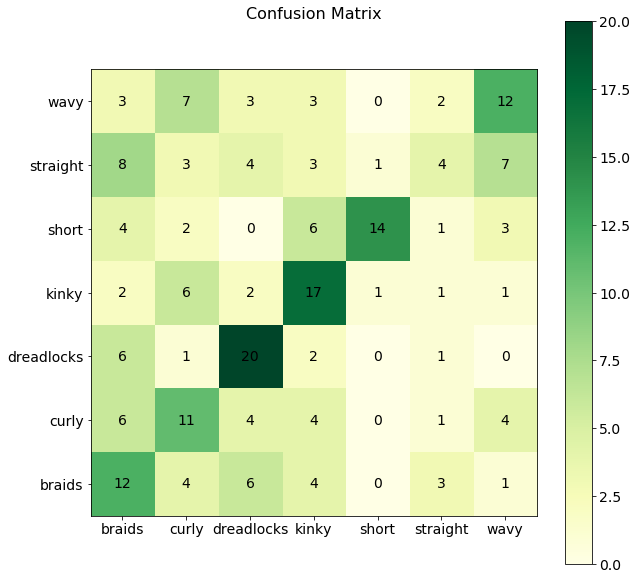

In [44]:
fig, ax = plt.subplots(figsize=(10,10))
im=ax.imshow(cm, origin='upper', cmap='YlGn')
ax.set_title('Confusion Matrix', fontsize = 16, y =1.1)
for (j,i),label in np.ndenumerate(cm):
    ax.text(i,j,label,ha='center',va='center', fontsize=14)
plt.xticks([0,1,2,3,4,5,6], ('braids','curly', 'dreadlocks','kinky', 'short' ,'straight', 'wavy'), fontsize=14)
plt.yticks([0,1,2,3,4,5,6], ('braids','curly', 'dreadlocks','kinky', 'short' ,'straight', 'wavy'), fontsize=14)
ax.set_ylim(-0.5, 6.5)
#ax.xaxis.set_ticks_position('top')
#ax.xaxis.set_label_position('top')
cb = plt.colorbar(im)
cb.ax.tick_params(labelsize=14) 
plt.savefig('/mntDrive/My Drive/Colab Notebooks/confusion_matrix.pdf')
plt.show()